This notebook is intended to explore how to read and store the data and what is the most confortable way to work with our dataset.

### Reading the data

In [1]:
# imports
import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# make sure you are working on an appropiate environment
print(sys.executable)

c:\Users\aitor\.conda\envs\ml_course\python.exe


In [3]:
# accessing the videos
path = '../data/pw1_A1_0315_part1.avi'
vid = cv2.VideoCapture(path)

In [179]:
# calculating global constants 
N_FRAMES = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = vid.read()
frame = frame[:,:,0]
N, M = frame.shape

In [149]:
# sets to 0 the borders of a one channel frame. 
# The width of the border is specified by n_pixels
def remove_borders(frame, n_pixels=15):
    frame[0:n_pixels, :] = frame[N-n_pixels:, :] = frame[:, 0:n_pixels] = frame[:, M-n_pixels:] = 0
    return frame

In [145]:
def get_frame(vid, frame_id):
    vid.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = vid.read()
    assert(ret==True)
    frame = frame[:,:,0]
    frame = remove_borders(frame)
    return frame


In [146]:
def get_next_frame(vid):
    ret, frame = vid.read()
    assert(ret==True)
    frame = frame[:,:,0]
    frame = remove_borders(frame)
    return frame

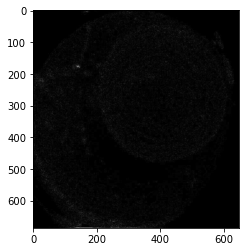

In [120]:
# comparing two frames
f1 = get_frame(vid, 0)
f2 = get_frame(vid, 7)
n, m = f1.shape
plt.imshow(np.abs(f1), cmap='gray', vmin=0, vmax=255)
plt.imshow(cv2.absdiff(f1,f2), cmap='gray')

In [182]:
# mean of frames
def mean_frame(vid, first_frame_id: int, n_frames: int):
    frame = get_frame(vid, first_frame_id)
    mean = np.zeros(frame.shape, dtype=int)
    for i in range(n_frames):
        frame = get_next_frame(vid)
        mean += frame
    mean = mean / n_frames
    return mean.astype(np.uint8)

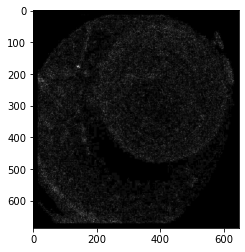

In [150]:
# comparing the mean of some consecutive frames with one frame
mn = mean_frame(vid, 0, 10)
f0 = get_frame(vid, 0)
plt.imshow(cv2.absdiff(mn, f0), cmap='gray')

10


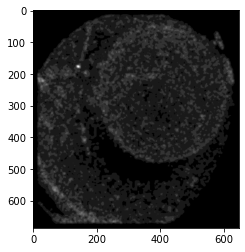

In [158]:
# Convolute with lowpass filter
# Blurs an image using the normalized box filter
kernel_size = (7,7)
blurred_f0_mov = cv2.blur(cv2.absdiff(mn, f0), kernel_size)
plt.imshow(blurred_f0_mov, cmap='gray')
print(np.max(blurred_f0_mov))

In [162]:
indmax = np.argmax(blurred_f0_mov)
print(indmax)
i_max = indmax // M
j_max = indmax % M
print(i_max, j_max, blurred_f0_mov[i_max, j_max])

114837
177 141 10


In [175]:
# get labels from .txt file
# input: path of the file
# output: dictionary where key = slice number, value = true (i, j) coordinates of the worm

def get_labels(path):
    file = open(path, 'r')
    lines = file.readlines()
    slice = 0
    ret = {}
    for i, line in enumerate(lines):
        fields = line.split()
        if i == 0 or fields[7] == slice:
            continue
        true_i = float(fields[6])
        true_j = float(fields[5])
        slice = int(fields[7])
        ret[slice] = (true_i, true_j)
    return ret

labels = get_labels('../data/pw1_A1_0315_part1.txt')
print(labels[345])

(177.5, 144.167)
2
(178.5, 143.375)


In [206]:
# hyperparameter R: 
# we don't search outside the ball of radius R (with norm $\ell ^ \infty$) 
# with center at the previous estimate  
def get_position_estimate(frame, background, prev_estimate=None, R=20):
    blurred_f0_mov = cv2.blur(cv2.absdiff(mn, f0), kernel_size) #idea: instead of absdiff, do max(0, f0-mn), as the worm is bright
    if prev_estimate != None:
        i_min = max(0, prev_estimate[0] - R)
        i_max = min(N, prev_estimate[0] + R)
        j_min = max(0, prev_estimate[1] - R)
        j_max = min(M, prev_estimate[1] + R)
        # print(i_min, i_max, j_min, j_max)
        blurred_f0_mov[0:i_min, :] = blurred_f0_mov[i_max:, :] = blurred_f0_mov[:, 0:j_min] = blurred_f0_mov[:, j_max:] = 0

    plt.imshow(blurred_f0_mov, cmap='gray')
    indmax = np.argmax(blurred_f0_mov)
    i_hat = indmax // M
    j_hat = indmax % M
    return i_hat, j_hat

Slice: 5 	True pos: (177.5, 144.167) 	Estimated pos: (178, 146)
Slice: 6 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 7 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 8 	True pos: (177.5, 144.167) 	Estimated pos: (177, 146)
Slice: 9 	True pos: (177.5, 144.167) 	Estimated pos: (179, 145)
Slice: 10 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 11 	True pos: (177.5, 144.167) 	Estimated pos: (177, 146)
Slice: 12 	True pos: (177.5, 144.167) 	Estimated pos: (179, 145)
Slice: 13 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 14 	True pos: (177.5, 144.167) 	Estimated pos: (179, 145)
Slice: 15 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 16 	True pos: (177.5, 144.167) 	Estimated pos: (179, 145)
Slice: 17 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 18 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 19 	True pos: (177.5, 144.167) 	Estimated pos: (177, 145)
Slice: 20 	True pos: (177.5, 1

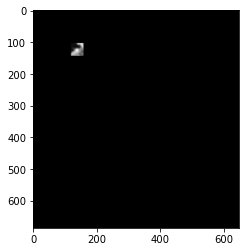

In [209]:
# main framework

avg_window = 11
half_window = (avg_window - 1) // 2
kernel_size = (7,7) # for the lowpass filter

# fill queue
q = []
q.append(get_frame(vid, 0))
for _ in range(avg_window-1):
    q.append(get_next_frame(vid))

# first estimate
mn = mean_frame(vid, 0, avg_window)
f0 = get_frame(vid, half_window)
pos_hat = get_position_estimate(f0, mn)


for t in range(half_window, N_FRAMES - half_window - 1):
    right_frame = get_next_frame(vid)
    mn = (mn.astype(int) + (right_frame.astype(int) - q.pop(0).astype(int)) / avg_window).astype(np.uint8) # update mean
    q.append(right_frame)
    pos_hat = get_position_estimate(q[half_window], mn, pos_hat)
    print('Slice:', t, '\tTrue pos:', labels[t] if t in labels else '(???, ???)', '\tEstimated pos:', pos_hat)


In [192]:
x = (-3, 8)
y = np.clip(x, 0, 10)
y[0:0]

array([], dtype=int32)